In [1]:
import scipy
from scipy import stats
import pickle 
from sklearn.neighbors import KernelDensity

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections
from pycocotools.coco import COCO
import requests
import plotly.express as px
import plotly.graph_objects as go
from os import listdir
from os.path import isfile, join
import base64
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import operator
import plotly.figure_factory as ff
import scipy
import pickle 
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
from collections import OrderedDict
from random import sample


/tmp/ipykernel_27203/3201064205.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [14]:
def stratified_beta_multilabel(df, alpha, beta, model, training_budget, dataset='animals'):
    #df = df.sample(frac=0.5, replace=False, random_state=1)
    targets = df['Target'].tolist()
    targets = [i[0] for i in targets]
    df['Target'] = targets
    orig_df = df.copy()
    all_ids = df['question_id'].to_list()

    # sampled_question_ids = []
    # sampled_variabilities = []
    # sampled_confidence = []
    # sampled_correctness = []
    # sampled_targets = []

    #unique_targets = df['Target'].unique()
    targets_list = np.array(df['Target'].tolist())
    question_ids = np.array(df['question_id'].to_list())
    #confidence = np.array(df['confidence'].tolist())
    variability = np.array(df['variability'].tolist())


    targets_multilabel =[] # unique targets in vqa dataset 
    for i in targets_list:
        target_list = [x.strip() for x in i.split(',')]
        targets_multilabel.extend(target_list)
    unique_targets = set(targets_multilabel)

    df_variability = pd.DataFrame({'variability':variability, 'question_id':question_ids})
    bins = pd.cut(variability, bins=np.linspace(0, 0.5, 6), right=True, retbins=True)
    df_variability['bins'] = bins[0]
    
    beta_distribution = scipy.stats.beta(alpha, beta)
    sampling_percentages = [beta_distribution.cdf(0.2), beta_distribution.cdf(0.4)-beta_distribution.cdf(0.2), beta_distribution.cdf(0.6)-beta_distribution.cdf(0.4), beta_distribution.cdf(0.8)-beta_distribution.cdf(0.6), beta_distribution.cdf(1) - beta_distribution.cdf(0.8)]
    #sampling_percentages = [beta_distribution.cdf(0.25), beta_distribution.cdf(0.5)-beta_distribution.cdf(0.25), beta_distribution.cdf(0.75)-beta_distribution.cdf(0.5), beta_distribution.cdf(1)-beta_distribution.cdf(0.75)]
    unique_bins = df_variability['bins'].unique().tolist()
    print(unique_bins)

    first_bin = df_variability.loc[df_variability['bins'] == unique_bins[2]]
    second_bin = df_variability.loc[df_variability['bins'] == unique_bins[0]]
    third_bin = df_variability.loc[df_variability['bins'] == unique_bins[1]]
    fourth_bin = df_variability.loc[df_variability['bins'] == unique_bins[3]]
    fifth_bin = df_variability.loc[df_variability['bins'] == unique_bins[4]]

    all_bins = [first_bin, second_bin, third_bin, fourth_bin, fifth_bin]
    final_sample = []
    final_sample_ids = []
    for idx, sampling_percentage in enumerate(sampling_percentages):
        sampled_points = all_bins[idx].sample(frac=sampling_percentage, replace=True)
        final_sample.extend(sampled_points['variability'].tolist())
        final_sample_ids.extend(sampled_points['question_id'].tolist())
    sns.histplot(final_sample, kde=True)
    total_samples = round((training_budget*0.01) * len(all_ids))
    print("Total samples: ", total_samples)
    print("sample size: ", len(set(final_sample)))


    save_path = '../../../src/dataset_selection/sampling/samples/'+model+'/'+dataset+'/beta/var_stratified/seed_'+str(965)+'/alpha_'+str(alpha)+'_beta_'+str(beta)+'_budget_'+str(training_budget)+'.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump(list(set(final_sample_ids)), f)

    unique_targets_sample = orig_df[orig_df['question_id'].isin(final_sample_ids)]
    sampled_targets_unique =[] # unique targets in vqa dataset 
    targets_list_sampled = np.array(unique_targets_sample['Target'].tolist())
    for i in targets_list_sampled:
        target_list = [x.strip() for x in i.split(',')]
        sampled_targets_unique.extend(target_list)
    unique_targets_sampled = set(sampled_targets_unique)

    # sampled_targets_unique = [] # unique targets in sampled data
    # sampled_targets = set(unique_targets_sample['Target'].unique())
    # for sample in sampled_targets:
    #     target_list = [x.strip() for x in sample.split(',')]
    #     sampled_targets_unique.extend(target_list)
    # sampled_targets_unique = set(sampled_targets_unique)
    targets_excluded = unique_targets - unique_targets_sampled
    print("TARGETS excluded: ", len(targets_excluded))

    print("unique targets max variability per class: ", len(set(unique_targets_sampled)))
    print('samples - max variability per class: ', len(set(final_sample)))
    print('all_samples - max variability per class: ', len(all_ids))

[Interval(0.1, 0.2, closed='right'), Interval(0.2, 0.3, closed='right'), Interval(0.0, 0.1, closed='right'), Interval(0.3, 0.4, closed='right'), Interval(0.4, 0.5, closed='right')]
Total samples:  198205
sample size:  134534
TARGETS excluded:  53
unique targets max variability per class:  3075
samples - max variability per class:  134534
all_samples - max variability per class:  619390


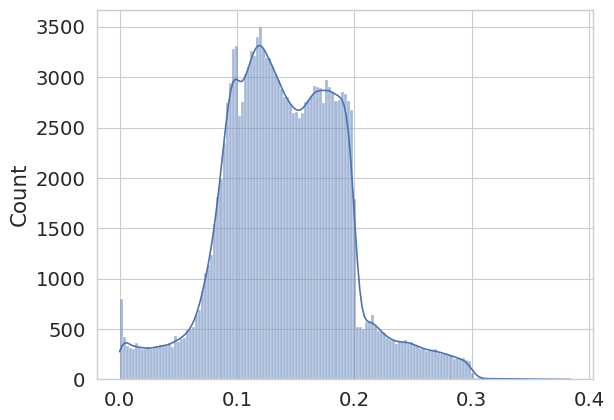

In [16]:

sampling_dataset = 'multilabel_full'
sampling_model = 'LXR111'


base_path = '../../../snap/vqa/lxr111_multilabel_full_run_3/'
df = pd.read_pickle(base_path+"datamap_metrics.pkl")

stratified_beta_multilabel(df, 2, 8, sampling_model, 32, dataset=sampling_dataset)